# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.image import resize


# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Evaluating the first round of training of the ResNet 50 Model 
- To overcome the challenges faced in the first train of the model, such as overfitting and class imbalance, hence we will apply data augmentation, model regularisation and early stopping. 


# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance. 

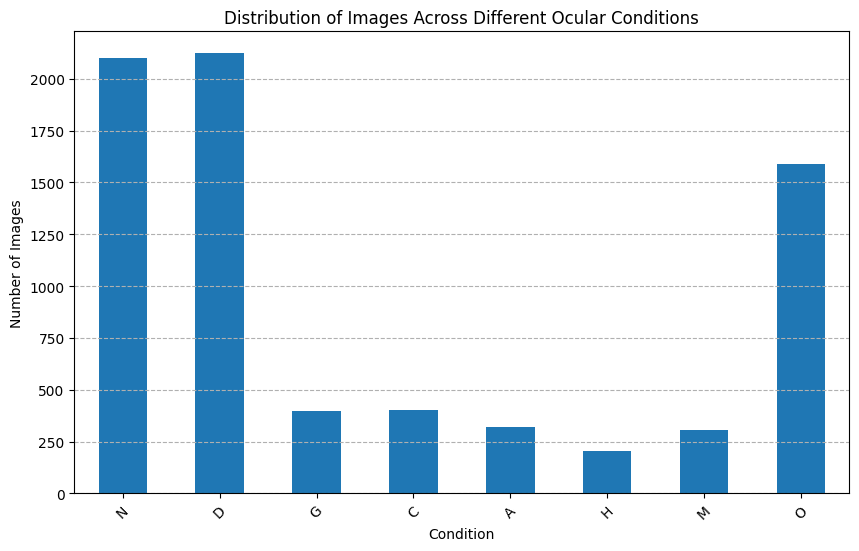

In [3]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [4]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [5]:
# Split the DataFrame into training and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=42)

Filtering the Minority Classes

N    1709
D    1677
G     313
C     320
A     260
H     158
M     239
O    1261
dtype: int64


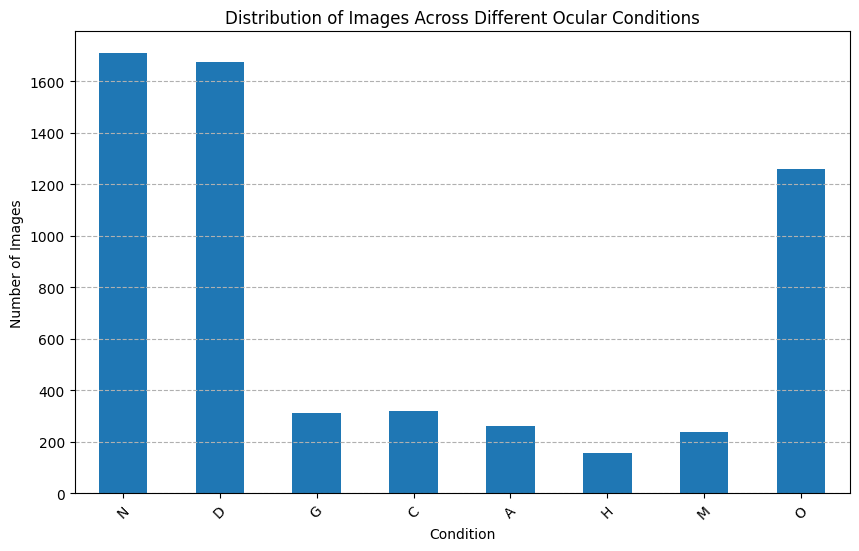

In [6]:
train_class_distribution = df_train[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(train_class_distribution)

# Plotting
plt.figure(figsize=(10, 6))
train_class_distribution.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()


In [82]:
class_distribution = np.sum(df_train['target'].tolist(), axis=0)
# Define your class labels
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")

Class N: 2304
Class D: 1275
Class G: 223
Class C: 235
Class A: 220
Class H: 100
Class M: 184
Class O: 572


In [6]:
# Current counts for each class after augmentation
current_counts_after_augmentation = {
    'N': 2304,
    'D': 1275,
    'G': 223,
    'C': 235,
    'A': 220,
    'H': 100,
    'M': 184,
    'O': 572
}

target_count = max(current_counts_after_augmentation.values())  # From the provided original counts

# Calculate the number of additional augmentations needed for each class to reach the target count
augmentations_needed = {class_label: max(0, target_count - current_count)
                        for class_label, current_count in current_counts_after_augmentation.items()}

# Update the dictionary to have numeric indices if needed
# This assumes the class_labels are ordered as ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

augmentations_needed_numeric = {i: augmentations_needed[label] for i, label in enumerate(class_labels)}

augmentations_needed_numeric

{0: 0, 1: 1029, 2: 2081, 3: 2069, 4: 2084, 5: 2204, 6: 2120, 7: 1732}

In [3]:
import math

def calculate_augmentations_needed(current_distribution, target_count):
    # Calculate the augmentations needed for each class to reach the target count
    augmentations_needed_per_class = {
        class_label: target_count - count 
        for class_label, count in current_distribution.items() if count < target_count
    }
    
    # Calculate the total augmentations needed
    total_augmentations_needed = sum(augmentations_needed_per_class.values())
    
    # Calculate the average number of augmentations needed per image in each under-represented class
    augmentations_needed_per_image = {
        class_label: math.ceil(augmentations_needed / current_distribution[class_label])
        for class_label, augmentations_needed in augmentations_needed_per_class.items()
    }
    
    return augmentations_needed_per_image, total_augmentations_needed

# Use the function
current_distribution = {
    'N': 2304,
    'D': 1275,
    'G': 223,
    'C': 235,
    'A': 220,
    'H': 100,
    'M': 184,
    'O': 572
}
target_count = max(current_distribution.values())  # The target is the class with the maximum instances
augmentations_per_image, total_needed = calculate_augmentations_needed(current_distribution, target_count)

print(f"Augmentations needed per image (rounded up): {augmentations_per_image}")
print(f"Total augmentations needed (sum of rounded values): {total_needed}")



Augmentations needed per image (rounded up): {'D': 1, 'G': 10, 'C': 9, 'A': 10, 'H': 23, 'M': 12, 'O': 4}
Total augmentations needed (sum of rounded values): 13319


In [6]:
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

save_directory = 'dataset/augmented_images/'
os.makedirs(save_directory, exist_ok=True)

# The augmentations_needed dictionary now uses numerical indices as keys
augmentations_needed = { 0:0, 1:1, 2:10, 3:9, 4:10, 5:23, 6:12, 7:4 }



# Assuming df_train is your DataFrame and it has a 'target' column that is already in the correct format (list of integers)
def augment_and_save_image(row, save_directory, augmentation):
    img_path = os.path.join('dataset/ODIR-5K/Training Images', row['filename'])
    img = load_img(img_path)
    img = img.resize((256, 256))  # Resize image if necessary
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_image_paths = []

    # Determine the number of augmentations needed based on the target
    # Assume targets are in a list format, you might need to adjust this if stored differently
    targets = eval(row['target']) if isinstance(row['target'], str) else row['target']
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])

    for i in range(max_augmentations_needed):
        for batch in augmentation.flow(x, batch_size=1, save_prefix='aug_', save_format='jpeg'):
            # Create a unique filename using class index and augmentation index
            unique_filename = f'aug_{i}_{row["filename"]}'
            # Generate the full path for saving
            augmented_image_path = os.path.join(save_directory, unique_filename)
            # Save the image to the full path
            save_img(augmented_image_path, batch[0])
            # Append just the filename to the list
            augmented_image_paths.append(unique_filename)
            break  # Only save one image per augmentation to avoid infinite loop

    return augmented_image_paths, targets  # Return just the filenames and the original target list

# Example usage with ThreadPoolExecutor
updated_image_paths = []
updated_labels = []

with ThreadPoolExecutor(max_workers=4) as executor:
    tasks = []
    for index, row in df_train.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            paths, targets = future.result()
            # Extend the list of paths and labels only if paths are returned
            if paths:
                updated_image_paths.extend(paths)
                updated_labels.extend([targets] * len(paths))  # Duplicate the label for each augmented image
        except Exception as e:
            print(f"Error processing image: {e}")
            updated_image_paths.append(None)  # Append None to indicate an error occurred
            updated_labels.append(None)

# Check if lengths match and create DataFrame
if len(updated_image_paths) == len(updated_labels):
    df_augmented_minority = pd.DataFrame({'filename': updated_image_paths, 'target': updated_labels})
else:
    print("Error: The lengths of updated_image_paths and updated_labels are not the same.")


Augmenting Images:   0%|          | 0/5113 [00:00<?, ?it/s]

In [100]:

# Create a new DataFrame to hold the augmented image paths and labels
augmented_df = pd.DataFrame({'filename': updated_image_paths, 'target': updated_labels})

augmented_df.head()

# Save the augmented DataFrame to a CSV file

augmented_df.to_csv('dataset/augmented_df.csv', index=False)




In [10]:

class_distribution = np.sum(augmented_df['target'].tolist(), axis=0)
# Define your class labels
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")


Class N: 0
Class D: 1275
Class G: 2230
Class C: 2115
Class A: 2200
Class H: 2300
Class M: 2208
Class O: 2288


In [19]:
# Create a DataFrame to store the updated image paths and labels
if len(updated_image_paths) == len(updated_labels):
    df_augmented_minority = pd.DataFrame({'filename': updated_image_paths, 'target': updated_labels})
else:
    print("Error: The lengths of updated_image_paths and updated_labels are not the same.")


In [11]:
# Concatenate the original and augmented minority class DataFrames
df_train_augmented = pd.concat([df_train, df_augmented_minority], axis=0)

df_train_augmented.head()



,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2273,3159.0,62.0,Male,3159_left.jpg,3159_right.jpg,normal fundus,normal fundus,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3159_right.jpg
5609,3315.0,57.0,Male,3315_left.jpg,3315_right.jpg,normal fundus,normal fundus,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3315_left.jpg
4614,2152.0,58.0,Female,2152_left.jpg,2152_right.jpg,cataract,normal fundus,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2152_left.jpg
3658,542.0,64.0,Male,542_left.jpg,542_right.jpg,diabetic retinopathy,maculopathy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",542_left.jpg
471,540.0,82.0,Male,540_left.jpg,540_right.jpg,normal fundus,dry age-related macular degeneration，diabetic ...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",540_right.jpg


In [101]:
#save df_train_augmented to csv

df_train_augmented.to_csv('dataset/df_train_augmented.csv', index=False)

Class N: 2304
Class D: 2550
Class G: 2453
Class C: 2350
Class A: 2420
Class H: 2400
Class M: 2392
Class O: 2860


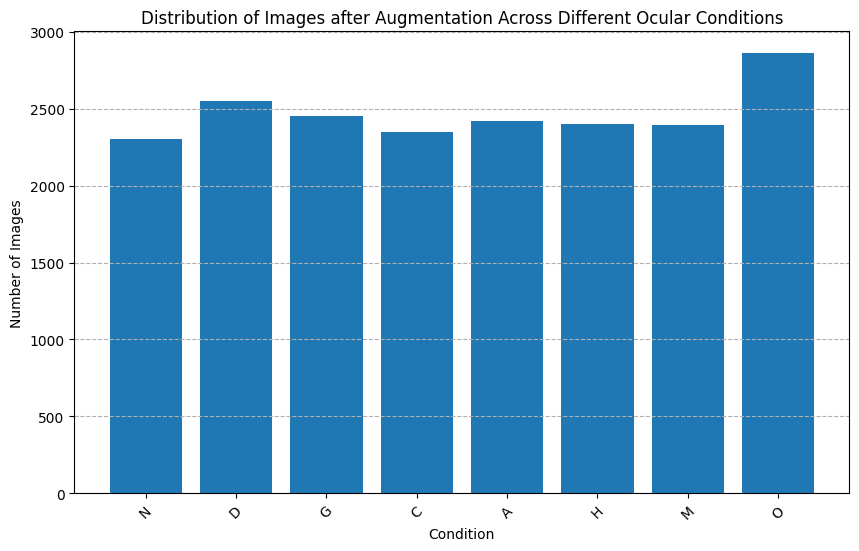

In [21]:
import ast
import numpy as np

# Convert string representation of list to actual list using ast.literal_eval
df_train_augmented['target'] = df_train_augmented['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all lists are of equal length (this step assumes all lists should be length 8)
# If some 'target' entries are not lists or are lists of different lengths, this will give an error
assert all(len(t) == 8 for t in df_train_augmented['target']), "Not all target lists are of length 8."

# Sum up all the target lists
class_distribution = np.sum(df_train_augmented['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")
    
# Plotting
plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Augmentation Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')



In [86]:
import numpy as np
import ast

# Preprocess target data
df_train_augmented['target'] = df_train_augmented['target'].apply(
    lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
    if isinstance(x, str) else np.array(x, dtype=np.float32)
)

# Check that all targets have the same length
assert df_train_augmented['target'].apply(len).nunique() == 1, "Targets have varying lengths."

# Check the processed targets
print(df_train_augmented['target'].iloc[0])

[1. 0. 0. 0. 0. 0. 0. 0.]


In [87]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)



train_generator = datagen.flow_from_dataframe(
    dataframe=df_train_augmented,  # Use the training part of the split
    directory='dataset/augmented_train_images/', 
    x_col='filename',
    y_col='target',
    subset='training',
    target_size=(224,224),  
    batch_size=32,
    class_mode='raw'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_train_augmented,  # Use the training part of the split
    directory='dataset/augmented_train_images/',
    x_col='filename',
    y_col='target',
    subset='validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='raw'
)

Found 15784 validated image filenames.
Found 3945 validated image filenames.


In [88]:
def stack_targets(generator):
    """
    Wrap a generator to stack its target arrays into a single 2D array.
    This only needs to be a generator that yields a tuple (inputs, targets).
    """
    for batch_x, batch_y in generator:
        # Stack the target arrays if they're not already stacked
        if isinstance(batch_y[0], np.ndarray):
            batch_y = np.stack(batch_y)
        yield batch_x, batch_y

# Wrap the existing train and validation generators
train_generator_wrapped = stack_targets(train_generator)
validation_generator_wrapped = stack_targets(validation_generator)

In [97]:
# Store original generator samples and batch_size
train_samples = train_generator.samples
train_batch_size = train_generator.batch_size
val_samples = validation_generator.samples
val_batch_size = validation_generator.batch_size

# Wrap the original generators
train_generator_wrapped = stack_targets(train_generator)
validation_generator_wrapped = stack_targets(validation_generator)

In [89]:
# Print the first few preprocessed target arrays to check them
for i in range(5):
    print(df_train_augmented['target'].iloc[i])

[1. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]


In [98]:
x, y = next(train_generator_wrapped)
print(x.shape)  # Should be (batch_size, 224, 224, 3)
print(y.shape)  # Should be (batch_size, num_classes)
print(y.dtype)  # Should be 'float32' or 'int32'

(32, 224, 224, 3)
(32, 8)
float32


In [107]:
# For the test set, you can create a separate ImageDataGenerator instance without a validation split
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,  # Use the separate test DataFrame
    directory='dataset/ODIR-5K/Training Images',
    x_col='filename',
    y_col='target',
    target_size=(224,224),
    batch_size=32,
    class_mode= 'raw',
    shuffle=False  # Typically, you don't want to shuffle the test set
)

Found 1279 validated image filenames.


In [109]:
import numpy as np
import ast

def preprocess_targets(generator):
    for batch_x, batch_y_str in generator:
        batch_y = np.stack([np.array(ast.literal_eval(y_str), dtype=np.float32) for y_str in batch_y_str])
        yield batch_x, batch_y

# Wrap the test_generator
test_generator_wrapped = preprocess_targets(test_generator)

# Now you can use test_generator_wrapped in the evaluate method
x_test, y_test = next(test_generator_wrapped)
print(x_test.shape)  # Should be (32, 224, 224, 3)
print(y_test.shape)  # Should be (32, 8)
print(y_test.dtype)  # Should be 'float32'


(32, 224, 224, 3)
(32, 8)
float32


In [108]:
x_test, y_test = next(test_generator)
print(x_test.shape)  # Should be (batch_size, 224, 224, 3)
print(y_test.shape)  # Should be (batch_size, 8)
print(y_test)

(32, 224, 224, 3)
(32,)
['[0, 1, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[1, 0, 0, 0, 0, 0, 0, 0]' '[0, 1, 0, 0, 0, 0, 0, 0]'
 '[1, 0, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[1, 0, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[0, 0, 0, 0, 0, 0, 1, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[0, 0, 1, 0, 0, 0, 0, 0]' '[0, 1, 0, 0, 0, 0, 0, 0]'
 '[1, 0, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[1, 0, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[0, 1, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[0, 0, 0, 0, 0, 0, 1, 0]' '[0, 1, 0, 0, 0, 0, 0, 0]'
 '[1, 0, 0, 0, 0, 0, 0, 0]' '[0, 0, 0, 0, 1, 0, 0, 0]'
 '[0, 1, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[0, 1, 0, 0, 0, 0, 0, 0]' '[0, 0, 0, 0, 0, 0, 0, 1]'
 '[0, 1, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[0, 1, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]'
 '[1, 0, 0, 0, 0, 0, 0, 0]' '[1, 0, 0, 0, 0, 0, 0, 0]']


# Loading and Visualising the Training Data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


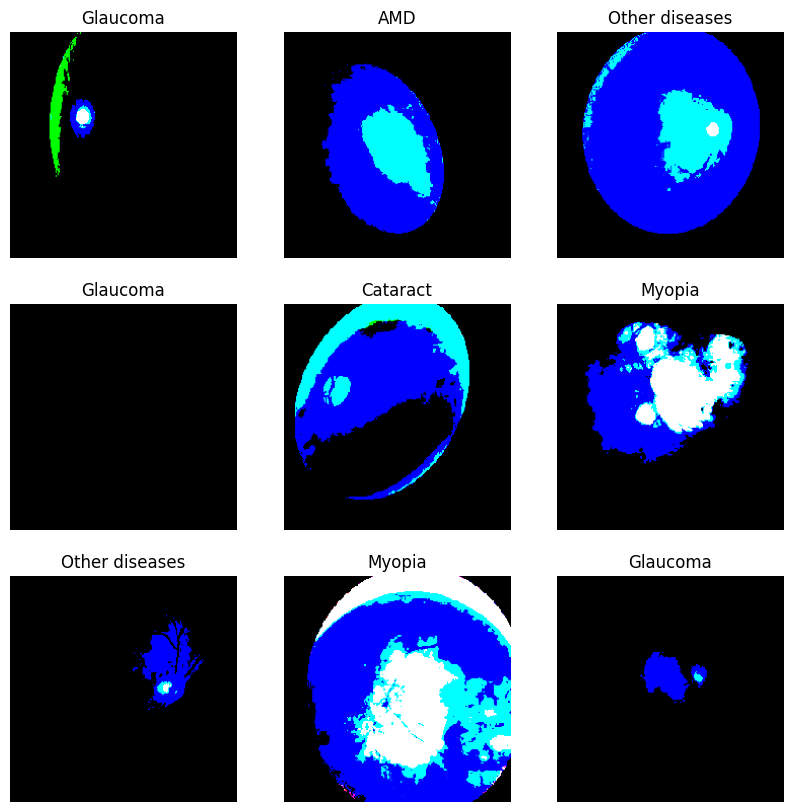

In [72]:
# Get the next batch of images from the training generator
images, labels = next(train_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']
# Plot the images and labels
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[np.argmax(labels[i])])
    plt.axis("off")


# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

# Early Stopping 
- This is implemented to prevent overfitting if the validation loss begins to rise consisenly as training goes on. 

In [ ]:
# Define the base pretrained model
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet'
)

# Create the model
resnet_50_model = Sequential([
    pretrained_model,
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dense(8, activation='sigmoid')  # Use 'sigmoid' for multi-label classification
])

# Set the base model's layers to non-trainable
for layer in pretrained_model.layers:
    layer.trainable = False

# Compile the model
resnet_50_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Use 'binary_crossentropy' for multi-label classification
    metrics=['accuracy']
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    patience=3,
    min_delta=0.001,
    restore_best_weights=True
)


In [ ]:
resnet_50_model.summary()

In [99]:
# Fit the model
epochs = 10
history = resnet_50_model.fit(
    train_generator_wrapped,
    validation_data=validation_generator_wrapped,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
493/493 [==============================] - 121s 245ms/step - loss: 0.4989 - accuracy: 0.6384 - val_loss: 0.4802 - val_accuracy: 0.5249
Epoch 2/10
493/493 [==============================] - 117s 238ms/step - loss: 0.3744 - accuracy: 0.6934 - val_loss: 0.4088 - val_accuracy: 0.5318
Epoch 3/10
493/493 [==============================] - 114s 231ms/step - loss: 0.3150 - accuracy: 0.7175 - val_loss: 0.3665 - val_accuracy: 0.5561
Epoch 4/10
493/493 [==============================] - 113s 230ms/step - loss: 0.2909 - accuracy: 0.7290 - val_loss: 0.3621 - val_accuracy: 0.5508
Epoch 5/10
493/493 [==============================] - 116s 235ms/step - loss: 0.2796 - accuracy: 0.7421 - val_loss: 0.3512 - val_accuracy: 0.5630
Epoch 6/10
493/493 [==============================] - 112s 228ms/step - loss: 0.2730 - accuracy: 0.7499 - val_loss: 0.3562 - val_accuracy: 0.5343
Epoch 7/10
493/493 [==============================] - 112s 228ms/step - loss: 0.2628 - accuracy: 0.7650 - val_loss: 0.3471 -

# Evaluating Model 

Model Accuracy Graph Analysis

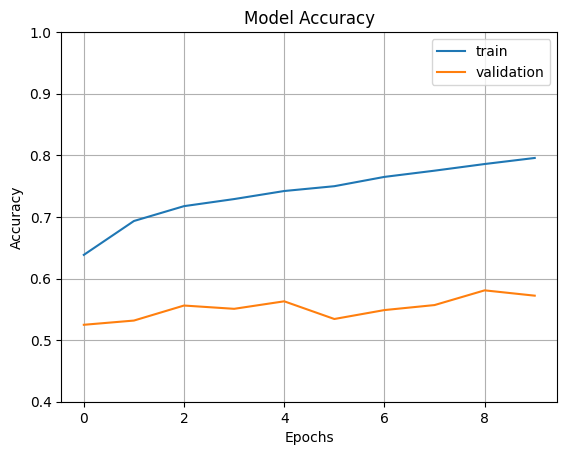

In [102]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

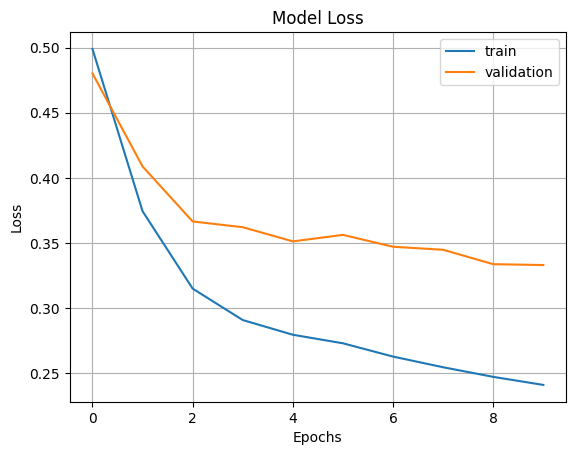

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

40/40 [==============================] - 17s 442ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


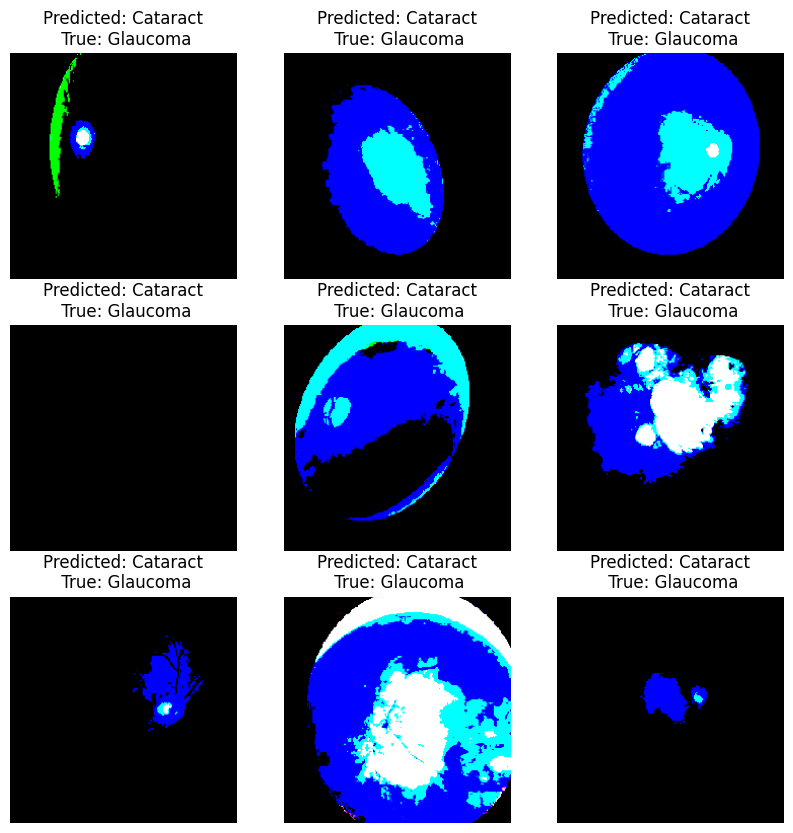

In [130]:
# Assuming these were stored from the original generator before wrapping
test_samples = test_generator.samples
test_batch_size = test_generator.batch_size

# Calculate the correct number of steps to cover all the samples
steps = np.ceil(test_samples / test_batch_size)

# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_generator_wrapped, steps=steps)

# Re-generate predictions with the corrected steps
predictions = resnet_50_model.predict(test_generator_wrapped, steps=steps)

# Get the predicted classes again
predicted_classes = (predictions > 0.5).astype(int)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
true_labels=class_labels[np.argmax(labels[i])]

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Predicted: {output_class}\n True: {true_labels}')
    plt.axis("off")
    

# Predictions Result Evaluation

In [112]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [131]:

# If necessary, convert string representations of lists to actual lists of integers
df_test['target'] = df_test['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Convert lists to a 2D NumPy array of integers
true_classes = np.array(df_test['target'].tolist())

# Check the data types and shapes
print("True classes shape:", true_classes.shape)
print("Predicted classes shape:", predicted_classes.shape)
print("True classes data type:", true_classes.dtype)
print("Predicted classes data type:", predicted_classes.dtype)

True classes shape: (1279, 8)
Predicted classes shape: (1279, 8)
True classes data type: int32
Predicted classes data type: int32


In [132]:

# Get the true classes from the DataFrame
true_classes = np.vstack(df_test['target'])


# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


              precision    recall  f1-score   support

      Normal       0.44      0.53      0.48       569
    Diabetes       0.27      0.21      0.24       333
    Glaucoma       0.05      0.02      0.02        61
    Cataract       0.04      0.05      0.05        58
         AMD       0.18      0.07      0.10        46
Hypertension       0.17      0.04      0.06        28
      Myopia       0.02      0.02      0.02        48
       Other       0.08      0.01      0.02       136

   micro avg       0.34      0.30      0.32      1279
   macro avg       0.16      0.12      0.12      1279
weighted avg       0.29      0.30      0.29      1279
 samples avg       0.26      0.30      0.27      1279



Balanced Accuracy Score 

In [133]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

ValueError: multilabel-indicator is not supported

Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [135]:
roc_auc = roc_auc_score(test_generator_wrapped.labels, predictions, average='macro', multi_class='ovo')
print('ROC AUC: {:.4f}'.format(roc_auc))

AttributeError: 'generator' object has no attribute 'labels'

Confusion Matrix 

In [136]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

ValueError: multilabel-indicator is not supported

# Prediction Evaluation

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model_v2.h5')